# CNN : CIFAR-10

### 환경 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 딥러닝 모델 설계할 때 활용하는 장비 확인 
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else :
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

### 데이터

In [4]:
train_dataset = datasets.CIFAR10(root = '/content/data/CIFAR-10',
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = '/content/data/CIFAR-10',
                                  train = False,
                                  transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Files already downloaded and verified


In [5]:
# 데이터 확인하기
for X_train, y_train in train_loader:
  print(X_train.size(), X_train.type())
  print(y_train.size(), y_train.type())
  break

torch.Size([32, 3, 32, 32]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


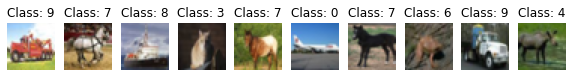

In [6]:
pltsize = 1
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

### 모델 설계

In [7]:
class CNN(nn.Module) :                  # 1
  def __init__(self) :                  # 2
    super(CNN, self).__init__()         # 3 
    self.conv1 = nn.Conv2d(             # 4
        in_channels = 3,                # 5
        out_channels = 8,               # 6
        kernel_size = 3,                # 7
        padding = 1)                    # 8
    self.conv2 = nn.Conv2d(             # 9
        in_channels = 8,               # 10
        out_channels = 16,              # 11
        kernel_size = 3,                # 12
        padding = 1)                    # 13
    self.pool = nn.MaxPool2d(           # 14
        kernel_size = 2,                # 15
        stride = 2)                     # 16
    self.fc1 = nn.Linear(8 * 8 * 16, 64)# 17
    self.fc2 = nn.Linear(64, 32)        # 18   
    self.fc3 = nn.Linear(32, 10)        # 19
   
  def forward(self, x):                 # 20
    x = self.conv1(x)                   # 21
    x = F.relu(x)                       # 22
    x = self.pool(x)                    # 23
    x = self.conv2(x)                   # 24
    x = F.relu(x)                       # 25
    x = self.pool(x)                    # 26

    x = x.view(-1, 8 * 8 * 16)          # 27
    x = self.fc1(x)                     # 28
    x = F.relu(x)                       # 29
    x = self.fc2(x)                     # 30
    x = F.relu(x)                       # 31
    x = self.fc3(x)                     # 32
    x = F.log_softmax(x)                 # 33
    return x                            # 34

1. nn.Module 클래스를 상속 받았을 때 nn.Module 클래스가 이용할 수 있는 함수를 그대로 이용할 수 있기 때문에 새로운 딥러닝 모델을 설계할 때 자주 이용된다.

2. CNN 클래스의 인스턴스를 생성했을 때 지니는 성질을 정의해주는 메서드이다.

3. nn.Module 내에 있는 메서드를 상속받아 이용한다.

4. 2차원의 이미지 데이터를 nn.Conv2d 메서드를 이용해 Convolution 연산을 하는 Filter를 정의한다.

5. 이미지에 직접 Convolution 연산을 진행하는 Filter의 크기는 상관없지만, 채널 수를 이미지의 채널 수와 동일하게 맞춰야 한다. 동일한 위치에 있으며 앞뒤로 존재하는 red, green, blue에 픽셀에 대해 동시에 Convolution 연산을 진행하기 위해서다. 따라서 이미지의 채널 수와 동일하게 채널 수를 '3'으로 설정했다.

6. Convolution 연산을 진행하는 Filter 개수를 설정한다. 여기서 설정해주는 Filter 개수만큼 Output의 depth가 정해진다. Filter 개수만큼 앞뒤로 쌓아 Feature Map을 형성하기 때문이다. 여기서는 '8개'로 설정했으므로 해당 Convolution 연산 결과는 depth가 '8인' Feature Map이 생성된다.

7. Filter의 크기를 설정해주는 부분이다. 스칼라 값으로 설정하려면 해당 스칼라 값의 가로 * 세로 크기인 Filter를 이용해야 한다. 즉, 여기서는 3 \* 3의 Filter 크기를 이용하게 된다. 3 x 3의 Filter가 이미지 위를 돌아다니면서 겹치는 영역에 대해 9개의 픽셀 값과 Filter 내에 있는 9개의 파라미터 값을 Convolution 연산으로 진행한다.

8. 5,6,7을 통해 세부 속성이 설정된 Filter가 이미지 위를 돌아다닐 때 이미지의 구석 부분은 중앙 부분에 비해 상대적으로 덜 연산된다. Filter가 돌아다니면서 겹치는 영역이 구석보다 중앙 부분이 당연히 자주 겹친다. 이를 방지하기 위해 이미지의 가장자리에 0을 채워 이미지 구석 부분과 중앙 부분의 Convolution 연산되는 횟수를 동일하게 맞춰주기 위해 Zero Padding을 설정해준다.

9. 14- Convolution을 통해 Feature Map이 생성됐을 때, Feature Map을 전부 이용하는 것이 아니라 부분적으로 이용한다. Convolution을 통해 다양한 수치가 생성되기 때문이다. nn.MaxPool2d는 2차원의 Feature Map 내에서 지정한 크기 내 가장 큰 Feature Map 값만 이용하겠다는 것을 의미이다. 

### 모델 확인

In [8]:
# Optimizer, Objective Function 설정하기
model = CNN().to(DEVICE)  # 1
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


1. CNN 모델을 기존에 선정한 'DEVICE'에 할당한다. 'DEVICE' 장비를 이용해 CNN 모델을 완성하기 위한 것이다.

#### 모델 요약 보기

In [9]:
import torchsummary
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                   [-1, 64]          65,600
            Linear-6                   [-1, 32]           2,080
            Linear-7                   [-1, 10]             330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.26
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


<ipython-input-7-8cf661b2cbcf>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)                 # 33


In [11]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):                    
  model.train()                                                   # 1
  for batch_idx, (image, label) in enumerate (train_loader):      # 2
    image = image.to(DEVICE)                                      # 3
    label = label.to(DEVICE)                                      # 4
    optimizer.zero_grad()                                         # 5
    output = model(image)                                         # 6
    loss = criterion(output, label)                               # 7
    loss.backward()                                               # 8
    optimizer.step()                                              # 9

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%] \tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image),
                                                                          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                          loss.item()))

1. 기존에 정의한 CNN 모델을 학습 상태로 지정한다.

2. 기존에 정의한 train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-Batch 단위로 묶여 저장돼 있다. 해당 train_loader 내에 Mini-Batch 단위로 저장된 데이터를 순서대로 이용해 CNN 모형을 학습시키겠다.

3. Mini-Batch 내에 있는 이미지 데이터를 이용해 CNN 모델을 학습하기 위해 기존에 정의한 장비에 할당한다.

4. Mini-Batch 내에 있는 이미지 데이터와 매칭된 레이블 데이터도 기존에 정의한 장비에 할당한다.

5. 기존에 정의한 장비에 이미지 데이터와 레이블 데이터를 할당했을 때, 과거에 이용한 Mini-Batch 내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient 값이 Optimizer에 할당돼 있으므로 Optimizer의 Gradient를 초기화한다.

6. 장비에 할당한 이미지 데이터를 CNN 모델의 Input으로 이용해 Output을 계산한다.

7. 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 Cross Entrophy를 이용해 Loss 값을 계산한다.

8. Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당한다.

9. 각 파라미터별로 할당된 Gradient 값을 이용해 파라미터 값을 업데이트한다.

In [12]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()                                                         # 1
  test_loss = 0                                                        # 2
  correct = 0                                                          # 3
  with torch.no_grad():                                                # 4
    for image, label in test_loader:                                   # 5 
      image = image.to(DEVICE)                                         # 6
      label = label.to(DEVICE)                                         # 7 
      output = model(image)                                            # 8
      test_loss += criterion(output, label).item()                     # 9
      prediction = output.max(1, keepdim = True)[1]                    # 10
      correct += prediction.eq(label.view_as(prediction)).sum().item() # 11
  test_loss /= len(test_loader.dataset)                                # 12
  test_accuracy = 100. * correct / len(test_loader.dataset)            # 13    
  return test_loss, test_accuracy                                      # 14

CNN 모델 학습 과정 또는 학습이 완료된 상태에서 CNN 모델의 성능을 평가하기 위해 evaluate 함수를 정의한다.

1. 학습 과정 속 또는 학습이 완료된 CNN 모델을 학습 상태가 아닌, 평가 상태로 지정한다.

2. 기존에 정의한 test_loader 내에 있는 데이터를 이용해 Loss 값을 계산하기 위해 test_loss를 0으로 임시 설정한다.

3. 학습 과정 속 또는 학습이 완료된 CNN 모델이 올바른 Class로 분류한 경우를 세기 위해 correct = 0으로 임시 설정한다.

4. CNN 모델을 평가하는 단계에서는 Gradient를 통해 파라미터 값들이 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 Gradient의 흐름을 억제한다.

5. 기존에 정의한 test_loader 내에 있는 데이터 역시 train_loader와 동일하게 Mini-Batch 단위로 저장돼 있다. Mini_Batch 내에 있는 이미지 데이터와 레이블 데이터에 반복문을 이용해 차례대로 접근한다.

6. Mini-Batch 내에 있는 이미지 데이터를 이용해 CNN 모델을 검증하기 위해 기존에 정의한 장비에 할당한다.

7. Mini-Batch 내에 있는 이미지 데이터와 매칭된 레이블 데이터도 기존에 정의한 장비에 할당한다.

8. 장비에 할당한 이미지 데이터를 CNN 모델의 Input으로 이용해 Output을 계산한다.

9. 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값을 계산한 결과값을 test_loss에 더해 업데이트한다.

10. CNN 모델의 Output 값은 크기가 '10'인 벡터 값이다. 계산된 벡터 값 내의 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단한다.

11. CNN 모델의 최종으로 예측한 클래스 값과 실제 레이블이 의미하느 클래스를 비교해 맞으면 correct에 더해 올발르게 예측한 횟수를 저장한다.

12. 현재까지 계산된 test_loss 값을 test_loader 내에 있는 Mini-Batch 개수만큼 나눠 평균 Loss 값으로 계산한다.

13. test_loader 데이터 중 얼마나 맞췄는 지를 계산해 정확도를 계산한다.

14. 계산된 test_loss 값과 test_accuracy 값을 반환한다.

### 모델학습

In [13]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

<ipython-input-7-8cf661b2cbcf>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)                 # 33


Train Epoch: 1 [0/50000(0%] 	Train Loss: 2.302835
Train Epoch: 1 [6400/50000(13%] 	Train Loss: 1.933167
Train Epoch: 1 [12800/50000(26%] 	Train Loss: 1.939707
Train Epoch: 1 [19200/50000(38%] 	Train Loss: 1.682745
Train Epoch: 1 [25600/50000(51%] 	Train Loss: 1.688642
Train Epoch: 1 [32000/50000(64%] 	Train Loss: 1.626541
Train Epoch: 1 [38400/50000(77%] 	Train Loss: 1.665012
Train Epoch: 1 [44800/50000(90%] 	Train Loss: 1.610892

[EPOCH: 1], 	Test Loss: 0.0456, 	Test Accuracy: 46.74 % 

Train Epoch: 2 [0/50000(0%] 	Train Loss: 1.165816
Train Epoch: 2 [6400/50000(13%] 	Train Loss: 1.226934
Train Epoch: 2 [12800/50000(26%] 	Train Loss: 1.789724
Train Epoch: 2 [19200/50000(38%] 	Train Loss: 1.430700
Train Epoch: 2 [25600/50000(51%] 	Train Loss: 1.383470
Train Epoch: 2 [32000/50000(64%] 	Train Loss: 1.199703
Train Epoch: 2 [38400/50000(77%] 	Train Loss: 1.344800
Train Epoch: 2 [44800/50000(90%] 	Train Loss: 1.564903

[EPOCH: 2], 	Test Loss: 0.0410, 	Test Accuracy: 52.39 % 

Train Epoch: 3